In [1]:
# importing libraries
import numpy as np                                          # For numerical operations
import pandas as pd                                         # For data manipulation and analysis
from sklearn.decomposition import PCA                       # Principal Component Analysis for dimensionality reduction
from sklearn.linear_model import LogisticRegression         # Logistic regression for classification
from sklearn.model_selection import train_test_split        # Splitting data into train and test sets
from sklearn.preprocessing import StandardScaler            # Standardizing features by removing the mean and scaling to unit variance
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score  # Metrics to evaluate the model
from sklearn.cluster import KMeans                          # k-means clustering
import sklearn.linear_model                                 # Provides various regression and classification models
import matplotlib.pyplot as plt                             # Plotting library
import seaborn as sns                                       # Advanced visualization library based on matplotlib

file    = '../final_ass/facebook_live_data.xlsx'
facebook = pd.read_excel(io = file)

# checking results
facebook.head(n = 10)

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,photo,2023-07-04 22:45:00,0,0,150,0,0,0,0,0
1,2,photo,2023-06-23 01:01:00,2,3,202,7,1,0,0,0
2,3,photo,2023-06-21 02:23:00,4,0,200,8,1,0,0,0
3,4,video,2023-06-14 05:16:00,100,30,303,23,1,5,0,0
4,5,video,2023-06-08 08:28:00,173,47,132,16,1,0,1,0
5,6,photo,2023-06-03 08:40:00,15,1,221,12,1,0,0,0
6,7,video,2023-06-01 22:34:00,0,1,37,0,0,0,0,0
7,8,photo,2023-05-22 05:55:00,0,0,81,2,2,0,0,0
8,9,photo,2023-05-18 02:48:00,8,0,281,11,1,0,0,0
9,10,photo,2023-05-13 01:43:00,11,6,61,4,1,0,0,0


In [2]:
# Check statistical details of the data
facebook.describe()

,status_id,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,2362.00000,2362,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000
mean,1181.50000,2022-01-17 21:45:45.673158144,233.729890,39.822185,221.147756,12.827265,1.282388,0.740051,0.260373,0.122777
min,1.00000,2017-09-27 02:58:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,591.25000,2021-03-25 16:10:15,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1181.50000,2023-01-28 04:36:30,4.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1771.75000,2023-05-17 11:30:30,23.000000,3.000000,186.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,2362.00000,2023-08-25 21:08:00,10960.000000,1260.000000,4315.000000,421.000000,278.000000,102.000000,46.000000,31.000000
std,681.99499,NaN,856.359157,123.780440,467.312818,40.997534,8.718397,4.111450,1.842239,0.904222


In [3]:
#Check shape of data
facebook.shape

(2362, 11)

# Principal components (PCA)

In [19]:
########################################
# scree_plot
########################################
def scree_plot(pca_object, export=False):
    """
    Visualizes a scree plot from a pca object and adds a vertical line to indicate
    the chosen cutoff point.

    PARAMETERS
    ----------
    pca_object | A fitted pca object
    export     | Set to True if you would like to save the scree plot to the
               | current working directory (default: False)
    """
    # building a scree plot
    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)

    # developing a scree plot
    explained_variances = pca_object.explained_variance_ratio_
    plt.plot(features,
             explained_variances,
             linewidth=3,
             marker='o',
             markersize=10,
             markeredgecolor='black',
             markerfacecolor='grey')

    # Specify the cutoff point as 3
    cutoff = 4  # Choosing 3 components as the cutoff

    # Draw vertical line at the cutoff point
    plt.axvline(x=cutoff-1, color='r', linestyle='--', label=f'Cutoff at Component {cutoff}')
    plt.legend()

    # setting more plot options
    plt.title('Scree Plot with Chosen Cutoff Point')
    plt.xlabel('PCA Feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)

    if export:
        # exporting the plot
        plt.savefig('./__analysis_images/pca_scree_plot.png')

    # displaying the plot
    plt.show()

########################################
# unsupervised_scaler
########################################
# standard_scaler
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [8]:
# subsetting continuous data
facebook_continuous = facebook[ ['num_comments','num_shares', 'num_likes', 'num_loves', 
                                 'num_wows', 'num_hahas', 'num_sads', 'num_angrys'] ]


# scaling the data
data_scaled = standard_scaler(df = facebook_continuous)

In [10]:
# checking scaling variance
print(np.var(data_scaled))

num_comments    1.0
num_shares      1.0
num_likes       1.0
num_loves       1.0
num_wows        1.0
num_hahas       1.0
num_sads        1.0
num_angrys      1.0
dtype: float64


C:\Users\fquin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [11]:
# INSTANTIATING a PCA object with no limit to principal components
pca = PCA(n_components = None,
            random_state = 702)


# FITTING and TRANSFORMING the scaled data
facebook_pca = pca.fit_transform(data_scaled)


# comparing dimensions of each DataFrame
print("Original shape:", data_scaled.shape)
print("PCA shape     :", facebook_pca.shape)

Original shape: (2362, 8)
PCA shape     : (2362, 8)


In [12]:
pd.DataFrame(data = facebook_pca)

,0,1,2,3,4,5,6,7
0,-0.619670,-0.006476,0.031211,-0.028140,0.069438,0.030553,0.011254,-0.000399
1,-0.469623,0.126667,0.013848,-0.028868,0.082735,-0.020934,-0.053784,-0.088186
2,-0.469004,0.125796,0.015559,-0.028346,0.089355,-0.017813,-0.058132,-0.121798
3,0.367677,0.240069,-0.089732,-0.314233,0.234662,0.932251,-0.089207,-0.068756
4,-0.019679,-0.278149,-0.276109,0.109002,0.151739,-0.213950,-0.170986,-0.007108
...,...,...,...,...,...,...,...,...
2357,-0.430884,0.084652,-0.004706,-0.030780,-0.039773,0.007068,-0.111433,-0.051283
2358,-0.667096,-0.222189,0.133994,-0.100760,0.215334,-0.003407,-0.002229,-0.001872
2359,-0.668470,-0.228442,0.136973,-0.102865,0.219563,-0.004391,-0.002620,-0.001914
2360,-0.669158,-0.231568,0.138463,-0.103917,0.221677,-0.004884,-0.002815,-0.001936


In [13]:
# component number counter
component_number = 0

# looping over each principal component
for variance in pca.explained_variance_ratio_:
    component_number += 1
    
    print(f"PC {component_number}: {variance.round(3)}")

PC 1: 0.409
PC 2: 0.128
PC 3: 0.115
PC 4: 0.11
PC 5: 0.1
PC 6: 0.077
PC 7: 0.045
PC 8: 0.017


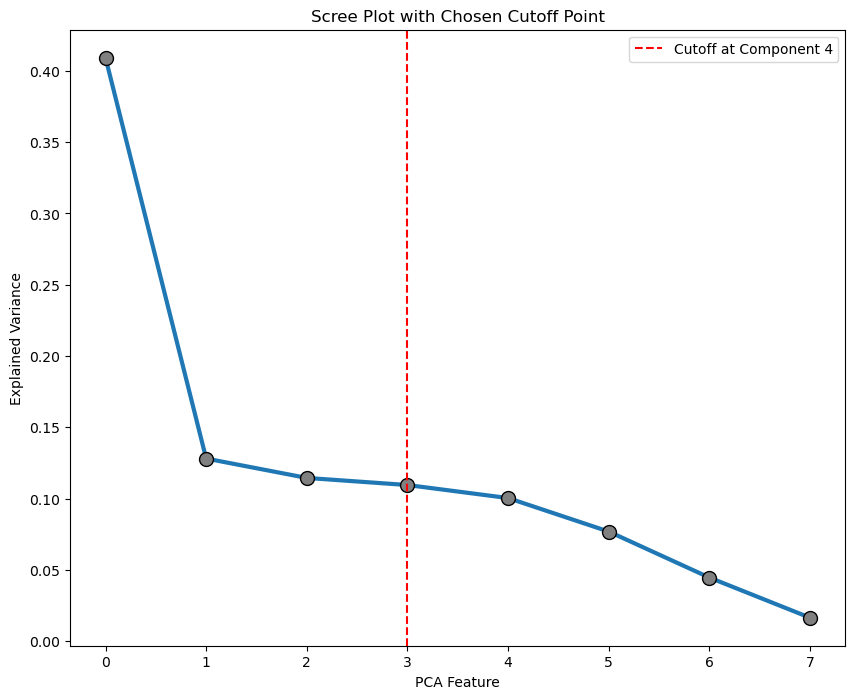

In [20]:
# calling the scree_plot function
scree_plot(pca_object = pca)

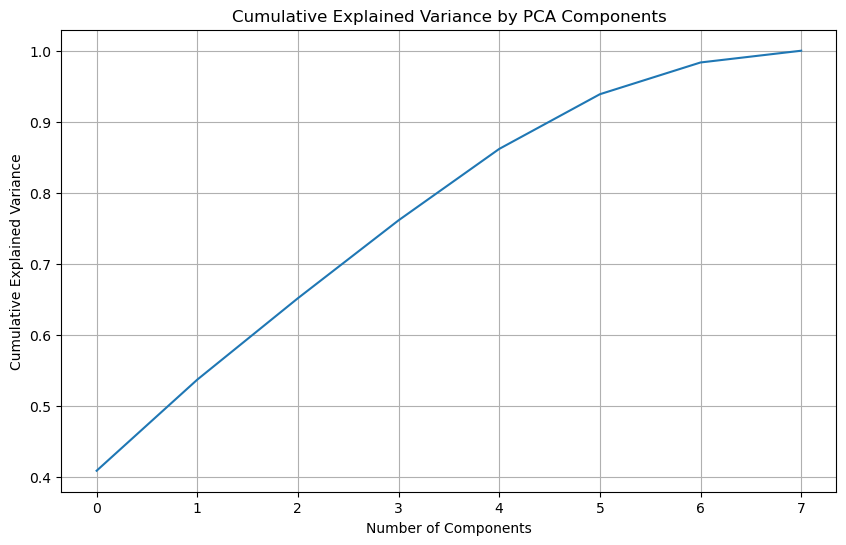

In [21]:
# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [15]:
# transposing pca components
factor_loadings_df = pd.DataFrame(np.transpose(pca.components_.round(decimals = 2)))


# naming rows as original features
factor_loadings_df = factor_loadings_df.set_index(data_scaled.columns)


# checking the result
print(factor_loadings_df)

                 0     1     2     3     4     5     6     7
num_comments  0.41 -0.31 -0.03 -0.20 -0.39 -0.18  0.67 -0.24
num_shares    0.49 -0.12  0.05 -0.17 -0.21 -0.22 -0.33  0.71
num_likes     0.16  0.73 -0.35  0.25 -0.49  0.11  0.05  0.00
num_loves     0.50  0.00  0.06 -0.08  0.01 -0.06 -0.56 -0.65
num_wows      0.30  0.48  0.08 -0.08  0.64 -0.42  0.29  0.04
num_hahas     0.37  0.01 -0.05 -0.20  0.28  0.84  0.14  0.12
num_sads      0.20 -0.35 -0.68  0.54  0.27 -0.09 -0.01  0.03
num_angrys    0.22 -0.04  0.63  0.72 -0.04  0.11  0.11  0.04


## Retained principal components

In [25]:
# Instantiating a new model using the first three principal components
pca_4 = PCA(n_components=4, random_state=702)

# Fitting the PCA model to the scaled data
pca_4.fit(data_scaled)

PCA(n_components=4, random_state=702)

In [26]:
#PCA Component Transposition 
# Accessing and transposing pca components
factor_loadings_4 = pd.DataFrame(np.transpose(pca_4.components_)).round(decimals=2)

# Naming rows as original features
factor_loadings_4 = factor_loadings_4.set_index(data_scaled.columns)

# Checking the result
print(factor_loadings_4)

                 0     1     2     3
num_comments  0.41 -0.31 -0.03 -0.20
num_shares    0.49 -0.12  0.05 -0.17
num_likes     0.16  0.73 -0.35  0.25
num_loves     0.50  0.00  0.06 -0.08
num_wows      0.30  0.48  0.08 -0.08
num_hahas     0.37  0.01 -0.05 -0.20
num_sads      0.20 -0.35 -0.68  0.54
num_angrys    0.22 -0.04  0.63  0.72


In [27]:
#Spectrum naming according to our interpreation looking into the max magnitudes on each column (picture attached below).

# Naming each principal component
factor_loadings_4.columns = ['Active Interaction',   
                              'Passive Endorsement', 
                              'Emotional Response',
                                'Complex Engagement']    

# Checking the result
factor_loadings_4

,Active Interaction,Passive Endorsement,Emotional Response,Complex Engagement
num_comments,0.41,-0.31,-0.03,-0.20
num_shares,0.49,-0.12,0.05,-0.17
num_likes,0.16,0.73,-0.35,0.25
num_loves,0.50,0.00,0.06,-0.08
num_wows,0.30,0.48,0.08,-0.08
num_hahas,0.37,0.01,-0.05,-0.20
num_sads,0.20,-0.35,-0.68,0.54
num_angrys,0.22,-0.04,0.63,0.72


# Clustering

In [33]:
# applying the unsupervised_scaler function
pca_rescaled = standard_scaler(df = factor_loadings_4)

# checking pre- and post-scaling variance
print(np.var(factor_loadings_df), '\n\n')
print(np.var(pca_rescaled))

0    0.015161
1    0.122250
2    0.123398
3    0.114769
4    0.124786
5    0.124711
6    0.121700
7    0.125298
dtype: float64 


Active Interaction     1.0
Passive Endorsement    1.0
Emotional Response     1.0
Complex Engagement     1.0
dtype: float64


C:\Users\fquin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [34]:
from sklearn.metrics import silhouette_score

# Assuming `pca_rescaled` is your data
for n_clusters in range(2, 8):  # Example range
    kmeans = KMeans(n_clusters=n_clusters, random_state=702)
    kmeans.fit(pca_rescaled)
    silhouette_avg = silhouette_score(pca_rescaled, kmeans.labels_)
    print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_avg)

C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 the average silhouette_score is : 0.30727838335603574


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 the average silhouette_score is : 0.36899547709775865


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4 the average silhouette_score is : 0.3822407555713468


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 the average silhouette_score is : 0.262904635861767


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 6 the average silhouette_score is : 0.17371091206055655


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 7 the average silhouette_score is : 0.13946514289621292


In [35]:
#Clustering
# INSTANTIATING a k-Means object:
customers_k_pca = KMeans(n_clusters   = 4     ,
                        n_init       = 'auto',
                        random_state = 702   )


# fitting the object to the data
customers_k_pca.fit(pca_rescaled)


# converting the clusters to a DataFrame
customers_kmeans_pca = pd.DataFrame(data = {'Cluster': customers_k_pca.labels_})


# checking the results
print(customers_kmeans_pca.iloc[: , 0].value_counts())

Cluster
0    4
1    2
3    1
2    1
Name: count, dtype: int64


C:\Users\fquin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [36]:
# storing cluster centers
centroids_pca = customers_k_pca.cluster_centers_


# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(data = centroids_pca).round(decimals = 2)


# renaming principal components
centroids_pca_df.columns = ['Active Interaction',   
                              'Passive Endorsement', 
                              'Emotional Response',
                                'Complex Engagement'] 

# checking results (clusters = rows, pc = columns)
centroids_pca_df.round(decimals = 2)

,Active Interaction,Passive Endorsement,Emotional Response,Complex Engagement
0,0.90,-0.44,0.12,-0.77
1,-0.82,1.59,-0.28,-0.04
2,-0.90,-0.26,1.90,1.84
3,-1.07,-1.14,-1.83,1.31


# Modeling

In [37]:
facebook['is_photo'] = facebook['status_type'].apply(lambda x: 1 if x == 'photo' else 0)

In [38]:
facebook.head(n=5)

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,is_photo
0,1,photo,2023-07-04 22:45:00,0,0,150,0,0,0,0,0,1
1,2,photo,2023-06-23 01:01:00,2,3,202,7,1,0,0,0,1
2,3,photo,2023-06-21 02:23:00,4,0,200,8,1,0,0,0,1
3,4,video,2023-06-14 05:16:00,100,30,303,23,1,5,0,0,0
4,5,video,2023-06-08 08:28:00,173,47,132,16,1,0,1,0,0


## Model 1 - Original X-features

In [39]:
# Selecting x- and y-data
x_features = ['num_comments','num_shares', 'num_likes', 'num_loves', 
            'num_wows', 'num_hahas', 'num_sads', 'num_angrys']

In [40]:
# selecting x- and y-data
x_data = facebook[x_features]
y_data = facebook["is_photo"]


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [41]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")


Train-Test Gap: 0.017
Test AUC Score: 0.678



In [42]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# Calculating accuracy and precision
accuracy = accuracy_score(y_true=y_test, y_pred=model_pred)
precision = precision_score(y_true=y_test, y_pred=model_pred)

# printing each result one-by-one
print(f"""
Accuracy: {accuracy.round(decimals=3)}
Precision: {precision.round(decimals=3)}
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Accuracy: 0.739
Precision: 0.714
True Negatives : 92
False Positives: 138
False Negatives: 16
True Positives : 345



## Model 2 - Retained Principal Components

In [45]:
# subsetting continuous data
facebook_continuous = facebook[ ['num_comments','num_shares', 'num_likes', 'num_loves', 
                                 'num_wows', 'num_hahas', 'num_sads', 'num_angrys'] ]


# scaling the data
data_scaled = standard_scaler(df = facebook_continuous)

In [46]:
# Instantiating a new model using the first three principal components
pca_4 = PCA(n_components=4, random_state=702)

# Fitting the PCA model to the scaled data
facebook_pca = pca_4.fit_transform(data_scaled)

In [47]:
# selecting x- and y-data
x_data = facebook_pca 
y_data = facebook["is_photo"]


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [48]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")


Train-Test Gap: 0.006
Test AUC Score: 0.67



In [49]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# Calculating accuracy and precision
accuracy = accuracy_score(y_true=y_test, y_pred=model_pred)
precision = precision_score(y_true=y_test, y_pred=model_pred)

# printing each result one-by-one
print(f"""
Accuracy: {accuracy.round(decimals=3)}
Precision: {precision.round(decimals=3)}
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Accuracy: 0.736
Precision: 0.708
True Negatives : 86
False Positives: 144
False Negatives: 12
True Positives : 349



## Model 3 - Retained clusters

In [51]:
# standardizing the data for clustering
pca_rescaled = standard_scaler(df = pd.DataFrame(data = facebook_pca))


# INSTANTIATING a k-Means object with clusters
customers_k_pca = KMeans(n_clusters   = 4 ,
                         n_init       = 'auto',
                         random_state = 702   )


# fitting the object to the data
customers_k_pca.fit(pca_rescaled)


# converting the clusters to a DataFrame
customers_kmeans_pca = pd.DataFrame({'Cluster': customers_k_pca.labels_})


# checking cluster populations
print(customers_kmeans_pca.iloc[: , 0].value_counts())

Cluster
1    2108
0     135
3     117
2       2
Name: count, dtype: int64


In [52]:
# factorizing cluster results 
cluster_df = pd.get_dummies(data       = customers_kmeans_pca['Cluster'],
                            drop_first = True).astype(dtype = int)


# checking results
cluster_df.value_counts(normalize = False).sort_index(ascending = False)

1  2  3
1  0  0    2108
0  1  0       2
   0  1     117
      0     135
Name: count, dtype: int64

In [53]:
# selecting x- and y-data
x_data = cluster_df
y_data = facebook['is_photo']


# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

In [54]:
# INSTANTIATING a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)


# FITTING the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING based on the testing set
model_pred = model_fit.predict(x_test) # predict_proba for multiclass


# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true  = y_test,
                            y_score = model_pred)


print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {round(roc_score, ndigits = 3)}
""")


Train-Test Gap: 0.011
Test AUC Score: 0.552



In [55]:
# storing cluster centers
centroids_pca = pd.DataFrame(data = customers_k_pca.cluster_centers_)


# checking cluster centers
centroids_pca.round(decimals = 2)

,0,1,2,3
0,0.21,2.54,-1.58,1.10
1,-0.21,-0.12,0.08,-0.06
2,3.26,-0.99,18.06,21.39
3,3.51,-0.75,0.13,-0.54


In [56]:
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# Calculating accuracy and precision
accuracy = accuracy_score(y_true=y_test, y_pred=model_pred)
precision = precision_score(y_true=y_test, y_pred=model_pred)

# printing each result one-by-one
print(f"""
Accuracy: {accuracy.round(decimals=3)}
Precision: {precision.round(decimals=3)}
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Accuracy: 0.65
Precision: 0.637
True Negatives : 26
False Positives: 204
False Negatives: 3
True Positives : 358



_____________________________________________________________________________________

# Analysis

In today's digital era, the dynamics of user engagement on social media platforms like Facebook play a crucial role in determining the effectiveness of content shared by sellers, particularly in live environments (1). 

The adoption of Facebook Live as a strategic tool for real-time interaction offers an invaluable opportunity to analyze engagement patterns. This analysis aims to provide insights into how different types of content perform, with a special focus on the role of photos. By employing a robust dataset on usage and engagement patterns for Facebook Live sellers in Thailand, this study seeks to identify the characteristics of content that maximize viewer interaction and participation. Understanding these patterns not only helps in crafting better content strategies but also enhances the interaction between sellers and potential customers, thereby potentially boosting sales and viewer retention.


The primary focus of this analysis is to understand the engagement levels associated with different types of content posted by Facebook Live sellers in Thailand. Specifically, the analysis will explore how photos compare with other content types in terms of eliciting reactions such as likes, loves, and other forms of engagement. By employing statistical and machine learning techniques, including principal component analysis and logistic regression, this study will dissect the nuances of user interaction across different content formats. Additionally, the investigation will extend to assessing the impact of specific reactions on the overall engagement of the content, providing a comprehensive overview of engagement strategies in the digital selling space.

## Perfomance of analysis reaction

Summarize the total engagements for photos versus other content types:

- Comments and Shares: Non-photo content generates significantly more comments and shares compared to photos, indicating higher discussion and sharing activity.

- Likes and Loves: While photos receive a decent number of likes, they lag considerably behind other content types in terms of loves, suggesting that non-photo content may evoke stronger affection or appreciation.

- Wows, Hahas, Sads, and Angrys: These reactions are less frequent for photos than for other content types, indicating that photos might be less polarizing or evoke less intense emotional reactions.


These findings suggest that while photos are good at generating likes, other forms of content (like videos or statuses) might be better at driving deeper or more varied forms of engagement like comments and shares. This can be particularly important for strategies that aim to maximize viewer interaction and engagement depth.


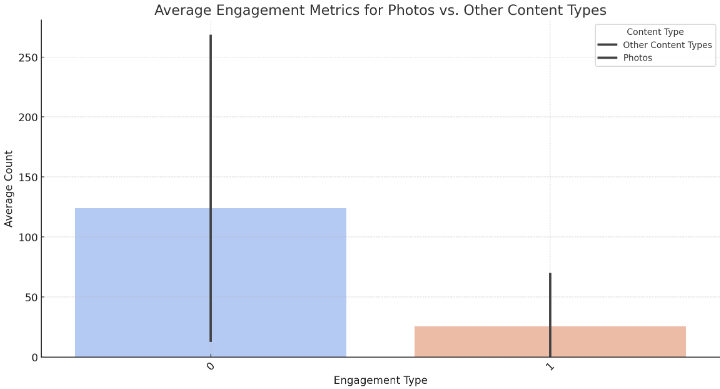



- Higher Engagement for Non-Photo Content: Non-photo content tends to generate substantially higher engagement in terms of comments, shares, loves, and even reactive metrics like wows, hahas, sads, and angry reactions.


- Likes: Photos, while still effective at gathering likes, do not outperform other content types significantly in this metric either.

## PCA

We defined our 4 PCA components from using not only the elbow method from scree plot above, plus the rationale for getting the most possible to explain a good amount of variance (70%-80%):

1. Cumulative Variance: The first 4 components cumulatively explain a significant portion of the variance (70%-80%), making them suitable for most analytical purposes.
    
2. Interpretability: Retaining 4 components strikes a balance between maximizing explained variance and maintaining interpretability of the data.
    
3. Dimensionality Reduction: Choosing 4 components substantially reduces the dimensionality of the dataset while retaining much of the information.

**Factor Loadings for the First Three Principal Components**

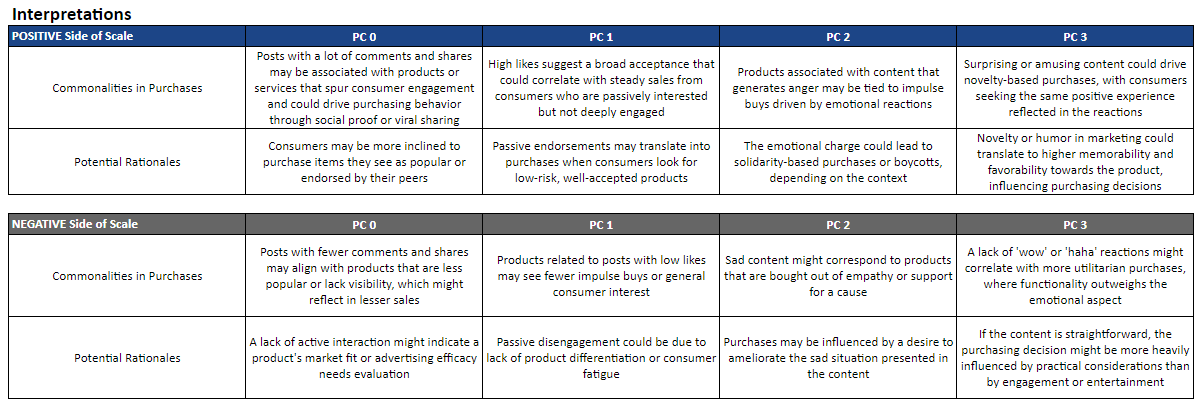

**Interpretation from the 4 Principal Components**


### PC0: Active Interaction
Reflects the level of user engagement through actions such as comments and shares. Higher values indicate content that likely spurs conversation and peer-to-peer interaction, which could be associated with increased social proof and potentially influence purchase behavior. Conversely, lower values may represent a lack of user interaction, suggesting that the content or the product it represents might not resonate with the audience, potentially impacting sales negatively.

### PC1: Passive Endorsement
Captures the general sentiment of approval with passive actions like 'likes'. It signifies broad content acceptance which might correlate with steady, low-effort consumer purchases. In contrast, lower scores on this component could indicate content that does not stand out to the audience, possibly affecting spontaneous buying interest.

### PC2: Emotional Response
Indicates the degree of emotional engagement provoked by the content, primarily through 'angry' and 'sad' reactions. High scores on this component may relate to purchases driven by strong emotions, whether positive (solidarity purchases) or negative (boycotts). Low scores might reflect content that evokes empathy, potentially influencing purchases made to support a cause.

### PC3: Complex Engagement
Reflects nuanced forms of engagement such as surprise or humor ('wow' and 'haha' reactions). High values may suggest that the content has a novelty factor or a humorous appeal, potentially leading to purchases for the experience associated with the product. Lower values could indicate that the content is more straightforward, likely resulting in purchases driven by practical needs rather than emotional or experiential factors.

## Clustering

### Determining the Number of Clusters
By examining silhouette scores, which assess how similar an object is to its own cluster versus others, we found:
- 2 clusters: 0.307
- 3 clusters: 0.369
- 4 clusters: 0.382
- 5 clusters: 0.263
- 6 clusters: 0.174
- 7 clusters: 0.139

The silhouette score peaks at 0.382 for four clusters, suggesting this as the ideal cluster count for maximum distinction and separation.

### Cluster Characteristics
The four clusters are characterized by the centroids (average values for each component within the cluster) as follows:

- **Cluster 0** shows high Active Interaction, indicating posts that prompt users to actively engage and possibly influence purchasing decisions.
- **Cluster 1** is defined by high Passive Endorsement, which may reflect a broad but passive content approval possibly correlating with consistent, low-effort purchases.
- **Cluster 2** has high Emotional Response and Complex Engagement, suggesting content that deeply resonates emotionally and may affect impulse buys or solidarity-based purchases.
- **Cluster 3** scores low across all components, indicating content that is less engaging and may correspond to more practical and necessity-driven purchases.

### Brief Insights
- **Cluster 0 (Active)**: Represents engaging and possibly viral content.
- **Cluster 1 (Passive)**: Captures content that is well-liked but not actively engaged with.
- **Cluster 2 (Emotional/Complex)**: Reflects content that evokes strong emotional reactions and complex engagement.
- **Cluster 3 (Low Engagement)**: Consists of posts that do not stimulate significant interaction or strong emotions.


### Examples of normal posts per cluster

**Cluster 0: The Active Segment - 🔥 Trend Alert! 🔥 Join the Challenge!**

Ever seen a cat do a human thing? 🐱👓 Now's your chance! Join our #CatBoss challenge and share your funniest videos of your furry friend acting like the boss of the house! 

👉 Swipe up to join the fun and don't forget to tag us and use #CatBoss for a chance to be featured on our story! Let's make this go viral! 🌟


**Cluster 1: The Passive Segment - 🌄 Peaceful Escape 🌄**

Today's serene landscape: A calm lake mirroring the majestic mountains beyond. A view so tranquil, it stops your scroll. 🏞️💙 

Hit like if you'd love to escape here! 🖼️✨

**Cluster 2: The Emotional/Complex Segment - 💖 Moments of Triumph 💖**

"Every mountain top is within reach if you just keep climbing." - Barry Finlay

Today, we celebrate Laura's incredible journey from recovery to her first marathon post-recovery. Her strength and determination inspire us all. 🏅👏 #Inspiration #RecoveryWarrior

Share your stories of personal triumph in the comments or send us a DM. Let's spread positivity and inspiration together! 💌

**Cluster 3: The Low Engagement Segment - 🕒 Store Hours Update 🕒**

Just a quick reminder: Our store hours have changed slightly. We are now open from 9 AM to 8 PM on weekdays and 10 AM to 6 PM on weekends. 🕰️🛒

Save this post for future reference! See you soon! 

## Model selection and rationale

Based on the performance metrics for the three models, here's a detailed analysis for my selection rationale:

### Selection Rationale and Best Model
Model 1 (Original x-features) is considered the best model due to the following reasons:

- **Balanced Metrics**: It offers a better balance between accuracy (0.739), precision (0.714), and AUC score (0.678) compared to the other models, indicating a robust prediction capability.
- **Consistency and Reliability**: The model maintains a moderate train-test gap (0.017) and a relatively higher AUC score, reflecting consistent performance across training and testing datasets.
- **Business Impact**: The model demonstrates a higher true positive rate and manageable false positives, which are critical for effective resource allocation and maximizing engagement strategies.
- **Risk Management**: Although false positives are higher than desirable, the impact is balanced by the high true positive rate, ensuring that potential high-engagement content is not missed.
- **Model Interpretability**: Utilizing original features without transformation allows for clear interpretations and actionable insights, which can be directly applied to business strategies.

### Model Results and Confusion Matrix Analysis
- **True Negatives (92)**: Effective identification of non-photo content, crucial for avoiding misallocation of resources.
- **False Positives (138)**: While high, it suggests room for refinement in model precision, yet the error rate is compensated by high true positives.
- **False Negatives (16)**: Relatively low, minimizing missed opportunities for engaging users with photo content.
- **True Positives (345)**: High, ensuring that the model effectively captures most of the engaging photo content.

### Business Risks and Recommendations
- **Reducing False Positives**: Focus on refining the model to decrease false positive rates, potentially through feature engineering or more advanced modeling techniques.
- **Maximizing True Positives**: Continue leveraging the strong true positive rate to boost user engagement through targeted content strategies.
- **Model Monitoring**: Regularly update and monitor the model performance to adapt to new trends and changes in user engagement behavior.

In conclusion, Model 1 not only performs well statistically but also aligns closely with business goals, making it the optimal choice for deployment.

## References

(1): Dehouche, N. (2020). Dataset on usage and engagement patterns for Facebook Live sellers in Thailand. Business Administration Division, Mahidol University International College. Available at https://pubmed.ncbi.nlm.nih.gov/32420434/